In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import joblib
import os

class CustomerProminencePredictor:
    def __init__(self, train=True, model_path='prominence_model.h5', scaler_path='scaler.save',
                 columns_path='training_columns.save'):
        self.model_path = model_path
        self.scaler_path = scaler_path
        self.columns_path = columns_path
        self.le_income = LabelEncoder()
        self.le_num_policies = LabelEncoder()

        if train:
            self.scaler = StandardScaler()
            self.model = None
            self.all_columns = None
        else:
            if not all(os.path.exists(path) for path in [model_path, scaler_path, columns_path]):
                raise FileNotFoundError("One or more model files are missing. Please train the model first.")
            self.scaler = joblib.load(scaler_path)
            # Load the full model (architecture + weights)
            self.model = load_model(model_path)
            self.all_columns = joblib.load(columns_path)
            self.le_income = joblib.load('le_income.save')
            self.le_num_policies = joblib.load('le_num_policies.save')

    def load_and_preprocess(self, data, is_train=True):
        """Preprocess data following user's notebook logic"""
        data = data.copy()

        if is_train:
            data['income'] = self.le_income.fit_transform(data['income'])
            data['num_policies'] = self.le_num_policies.fit_transform(data['num_policies'])
        else:
            data['income'] = self.le_income.transform(data['income'])
            data['num_policies'] = self.le_num_policies.transform(data['num_policies'])

        type_policy_map = {'Silver': 0, 'Gold': 1, 'Platinum': 2}
        data['type_of_policy'] = data['type_of_policy'].map(type_policy_map)

        categorical_cols = ['gender', 'area', 'qualification', 'policy']
        data = pd.get_dummies(data, columns=categorical_cols)

        numeric_cols = ['income', 'claim_amount', 'vintage', 'type_of_policy']
        for col in numeric_cols:
            data[col] = pd.to_numeric(data[col], errors='raise')

        if is_train:
            data[numeric_cols] = self.scaler.fit_transform(data[numeric_cols])
        else:
            data[numeric_cols] = self.scaler.transform(data[numeric_cols])

        data['claim_income_ratio'] = data['claim_amount'] / (data['income'] + 1e-6)
        data['policy_vintage'] = data['type_of_policy'] * data['vintage']

        if is_train:
            if 'cltv' not in data.columns:
                raise ValueError("'cltv' column missing in training data.")
            cltv_median = data['cltv'].median()
            data['Prominence'] = (data['cltv'] >= cltv_median).astype(int)
            print(f"Derived 'Prominence' from 'cltv' with median threshold: {cltv_median}")

            self.all_columns = [col for col in data.columns if col not in ['Prominence', 'id', 'cltv']]
            X = data.drop(['Prominence', 'id', 'cltv'], axis=1)
            y = data['Prominence']
            joblib.dump(self.le_income, 'le_income.save')
            joblib.dump(self.le_num_policies, 'le_num_policies.save')
            return X, y
        else:
            for col in self.all_columns:
                if col not in data.columns:
                    data[col] = 0
            return data[self.all_columns]

    def train_model(self, X_train, y_train, X_val, y_val):
        """Train neural network model"""
        self.model = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=32,
            verbose=1
        )

        self.model.save(self.model_path)
        joblib.dump(self.scaler, self.scaler_path)
        joblib.dump(self.all_columns, self.columns_path)

        return history

    def evaluate_model(self, X_test, y_test):
        """Evaluate model on test data"""
        y_pred_proba = self.model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba >= 0.5).astype(int)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    def preprocess_input(self, input_data):
        """Preprocess user input"""
        data = pd.DataFrame([input_data])

        data['income'] = self.le_income.transform([data['income'].iloc[0]])
        data['num_policies'] = self.le_num_policies.transform([data['num_policies'].iloc[0]])
        data['type_of_policy'] = {'Silver': 0, 'Gold': 1, 'Platinum': 2}[data['type_of_policy'].iloc[0]]

        gender_map = {'Male': [0, 1], 'Female': [1, 0]}
        data['gender_Female'], data['gender_Male'] = gender_map[data['gender'].iloc[0]]
        data.drop('gender', axis=1, inplace=True)

        area_map = {'Urban': [0, 1], 'Rural': [1, 0]}
        data['area_Rural'], data['area_Urban'] = area_map[data['area'].iloc[0]]
        data.drop('area', axis=1, inplace=True)

        qual_map = {'Bachelor': [1, 0, 0], 'High School': [0, 1, 0], 'Others': [0, 0, 1]}
        data['qualification_Bachelor'], data['qualification_High School'], data['qualification_Others'] = qual_map[data['qualification'].iloc[0]]
        data.drop('qualification', axis=1, inplace=True)

        policy_map = {'A': [1, 0, 0], 'B': [0, 1, 0], 'C': [0, 0, 1]}
        data['policy_A'], data['policy_B'], data['policy_C'] = policy_map[data['policy'].iloc[0]]
        data.drop('policy', axis=1, inplace=True)

        numeric_cols = ['income', 'claim_amount', 'vintage', 'type_of_policy']
        data[numeric_cols] = self.scaler.transform(data[numeric_cols])

        data['claim_income_ratio'] = data['claim_amount'] / (data['income'] + 1e-6)
        data['policy_vintage'] = data['type_of_policy'] * data['vintage']

        for col in self.all_columns:
            if col not in data.columns:
                data[col] = 0
        return data[self.all_columns]

    def predict_prominence(self, input_data):
        """Predict prominence for user input"""
        processed_data = self.preprocess_input(input_data)
        confidence = self.model.predict(processed_data, verbose=0)[0][0]
        prediction = int(confidence >= 0.5)
        return {
            'prominent': 'Yes' if prediction else 'No',
            'confidence': float(confidence) if prediction else float(1 - confidence),
            'probability_prominent': float(confidence),
            'interpretation': 'Above median CLTV' if prediction else 'Below median CLTV'
        }

Training Data Shape: (89392, 12)
Training Data Head:
    id  gender   area qualification         income  marital_status  vintage  \
0   1    Male  Urban      Bachelor         5L-10L               1        5   
1   2    Male  Rural   High School         5L-10L               0        8   
2   3    Male  Urban      Bachelor         5L-10L               1        8   
3   4  Female  Rural   High School         5L-10L               0        7   
4   5    Male  Urban   High School  More than 10L               1        6   

   claim_amount num_policies policy type_of_policy    cltv  
0          5790  More than 1      A       Platinum   64308  
1          5080  More than 1      A       Platinum  515400  
2          2599  More than 1      A       Platinum   64212  
3             0  More than 1      A       Platinum   97920  
4          3508  More than 1      A           Gold   59736  
Derived 'Prominence' from 'cltv' with median threshold: 66396.0
Preprocessed Training Features Shape: (89392, 1

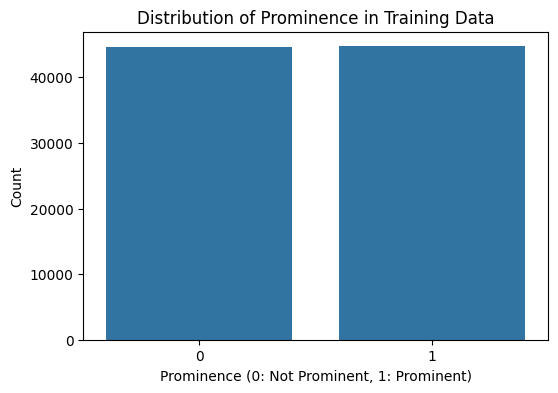

In [2]:
# Load training data
train_data = pd.read_csv('train_BRCpofr.csv')
print("Training Data Shape:", train_data.shape)
print("Training Data Head:\n", train_data.head())

# Preprocess training data
predictor = CustomerProminencePredictor(train=True)
X_train_full, y_train_full = predictor.load_and_preprocess(train_data, is_train=True)
print("Preprocessed Training Features Shape:", X_train_full.shape)

# Visualize Prominence distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_full)
plt.title('Distribution of Prominence in Training Data')
plt.xlabel('Prominence (0: Not Prominent, 1: Prominent)')
plt.ylabel('Count')
plt.show()

Epoch 1/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6846 - loss: 0.5980 - val_accuracy: 0.7453 - val_loss: 0.5406
Epoch 2/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7396 - loss: 0.5481 - val_accuracy: 0.7434 - val_loss: 0.5448
Epoch 3/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7347 - loss: 0.5517 - val_accuracy: 0.7448 - val_loss: 0.5409
Epoch 4/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7405 - loss: 0.5472 - val_accuracy: 0.7432 - val_loss: 0.5413
Epoch 5/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7406 - loss: 0.5442 - val_accuracy: 0.7453 - val_loss: 0.5410
Epoch 6/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7370 - loss: 0.5467 - val_accuracy: 0.7438 - val_loss: 0.5403
Epoch 7/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7394 - loss: 0.5446 - val_accuracy: 0.7452 - val_loss: 0.5425
Epoch 8/200
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7389 - 

Model trained and artifacts saved.


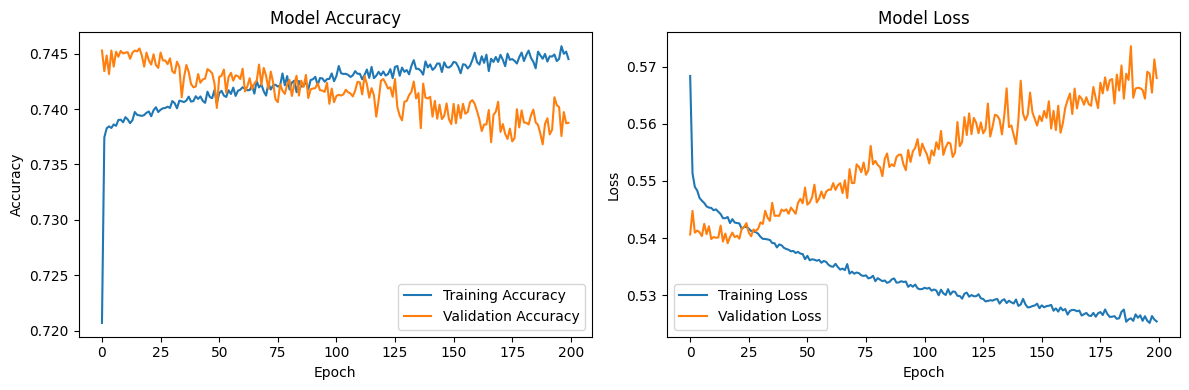

In [5]:
# Split training data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Train the model
history = predictor.train_model(X_train, y_train, X_val, y_val)
print("Model trained and artifacts saved.")

# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Derived 'Prominence' from 'cltv' with median threshold: 66396.0
Test Data Shape: (59595, 11)
Test Data Head:
       id  gender   area qualification         income  marital_status  vintage  \
0  89393  Female  Rural   High School         5L-10L               0        6   
1  89394  Female  Urban   High School          2L-5L               0        4   
2  89395    Male  Rural   High School         5L-10L               1        7   
3  89396  Female  Rural      Bachelor  More than 10L               1        2   
4  89397  Female  Urban   High School          2L-5L               0        5   

   claim_amount num_policies policy type_of_policy  
0          2134  More than 1      B         Silver  
1          4102  More than 1      A       Platinum  
2          2925  More than 1      B           Gold  
3             0  More than 1      B         Silver  
4         14059  More than 1      B         Silver  


Preprocessed Test Features Shape: (59595, 18)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.58      0.69     13427
           1       0.68      0.91      0.78     13391

    accuracy                           0.74     26818
   macro avg       0.77      0.74      0.74     26818
weighted avg       0.77      0.74      0.74     26818



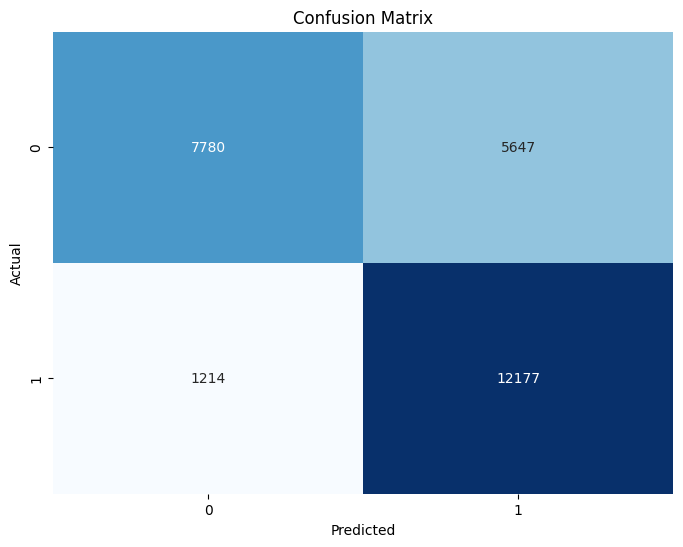

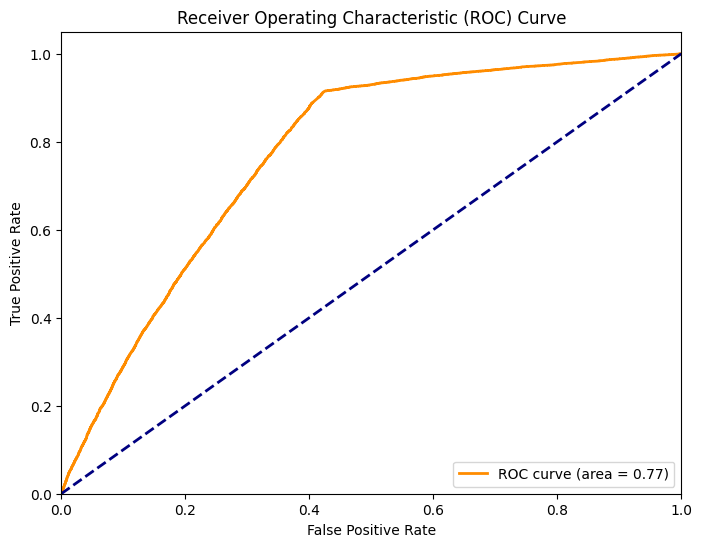

Evaluation completed on validation set (test data lacks Prominence).
Test predictions saved to 'test_predictions.csv'.


In [21]:
# Load training data to get validation set (since test data lacks 'Prominence')
train_data = pd.read_csv('train_BRCpofr.csv')
predictor_train = CustomerProminencePredictor(train=True)
X_train_full, y_train_full = predictor_train.load_and_preprocess(train_data, is_train=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Load test data
test_data = pd.read_csv('test_koRSKBP.csv')
print("Test Data Shape:", test_data.shape)
print("Test Data Head:\n", test_data.head())

# Preprocess test data
predictor = CustomerProminencePredictor(train=False)
X_test = predictor.load_and_preprocess(test_data, is_train=False)
print("Preprocessed Test Features Shape:", X_test.shape)

# Evaluate on validation set
predictor.evaluate_model(X_val, y_val)
print("Evaluation completed on validation set (test data lacks Prominence).")

# Predict on test data (for submission or further use)
test_predictions = predictor.model.predict(X_test, verbose=0)
test_data['Predicted_Prominence'] = (test_predictions >= 0.5).astype(int)
test_data['Prominence_Probability'] = test_predictions
test_data[['id', 'Predicted_Prominence', 'Prominence_Probability']].to_csv('test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'.")

In [1]:
def get_user_input():
    """Collect user input matching training data format"""
    print("\nPlease enter customer details (case-sensitive):")
    input_data = {}
    try:
        input_data['gender'] = input("Gender (Male/Female): ")
        input_data['area'] = input("Area (Urban/Rural): ")
        input_data['qualification'] = input("Qualification (Bachelor/High School/Others): ")
        input_data['income'] = input("Income (5L-10L/More than 10L/2L-5L/<=2L): ")
        input_data['marital_status'] = int(input("Marital Status (0 for Single, 1 for Married): "))
        input_data['vintage'] = float(input("Vintage (e.g., 5): "))
        input_data['claim_amount'] = float(input("Claim amount (e.g., 5790): "))
        input_data['num_policies'] = input("Number of policies (More than 1/1): ")
        input_data['policy'] = input("Policy (A/B/C): ")
        input_data['type_of_policy'] = input("Type of policy (Platinum/Gold/Silver): ")
    except ValueError:
        raise ValueError("Invalid input. Ensure numeric fields are numbers.")
    return input_data

# Predict for user input
predictor = CustomerProminencePredictor(train=False)
user_input = get_user_input()
result = predictor.predict_prominence(user_input)

# Display results
print("\n=== Prediction Results ===")
print(f"Prominent Customer: {result['prominent']}")
print(f"Confidence Score: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
print(f"Interpretation: {result['interpretation']}")
print(f"\nDetailed Probabilities:")
print(f"Probability of being Prominent: {result['probability_prominent']*100:.2f}%")
print(f"Probability of being Not Prominent: {(1 - result['probability_prominent'])*100:.2f}%")

# Visualize prediction probability
plt.figure(figsize=(6, 4))
probs = [result['probability_prominent'], 1 - result['probability_prominent']]
labels = ['Prominent', 'Not Prominent']
plt.bar(labels, probs, color=['green' if result['prominent'] == 'Yes' else 'red', 'red' if result['prominent'] == 'Yes' else 'green'])
plt.title('Prediction Probability')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.show()

NameError: name 'CustomerProminencePredictor' is not defined

# 

Training Data Shape: (89392, 12)
Training Data Head:
    id  gender   area qualification         income  marital_status  vintage  \
0   1    Male  Urban      Bachelor         5L-10L               1        5   
1   2    Male  Rural   High School         5L-10L               0        8   
2   3    Male  Urban      Bachelor         5L-10L               1        8   
3   4  Female  Rural   High School         5L-10L               0        7   
4   5    Male  Urban   High School  More than 10L               1        6   

   claim_amount num_policies policy type_of_policy    cltv  
0          5790  More than 1      A       Platinum   64308  
1          5080  More than 1      A       Platinum  515400  
2          2599  More than 1      A       Platinum   64212  
3             0  More than 1      A       Platinum   97920  
4          3508  More than 1      A           Gold   59736  
Derived 'Prominence' from 'cltv' with median threshold: 66396.0
Preprocessed Training Features Shape: (89392, 1

Model training completed.


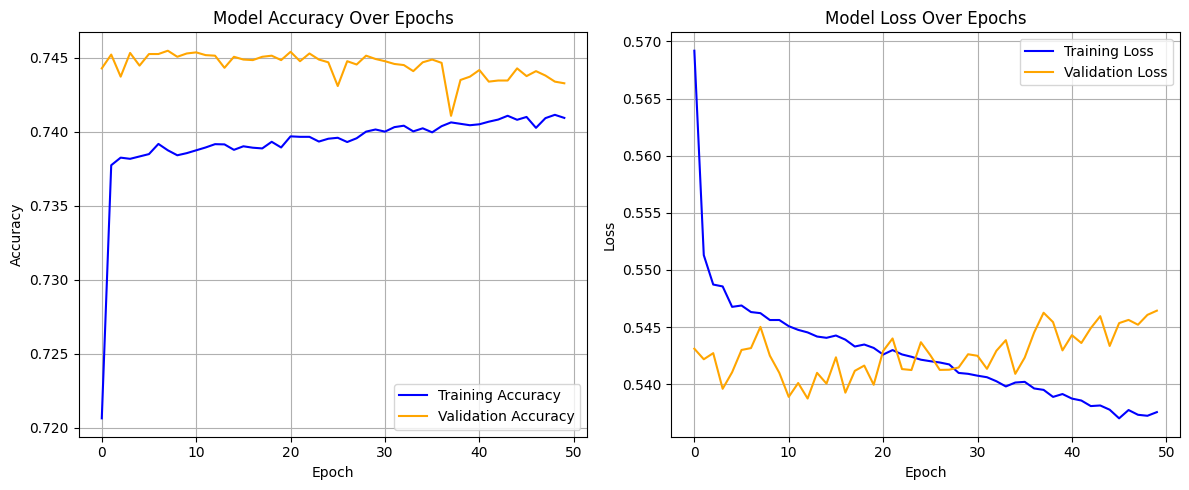


Evaluating Model on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.58      0.69     13427
           1       0.68      0.91      0.78     13391

    accuracy                           0.74     26818
   macro avg       0.77      0.74      0.74     26818
weighted avg       0.77      0.74      0.74     26818



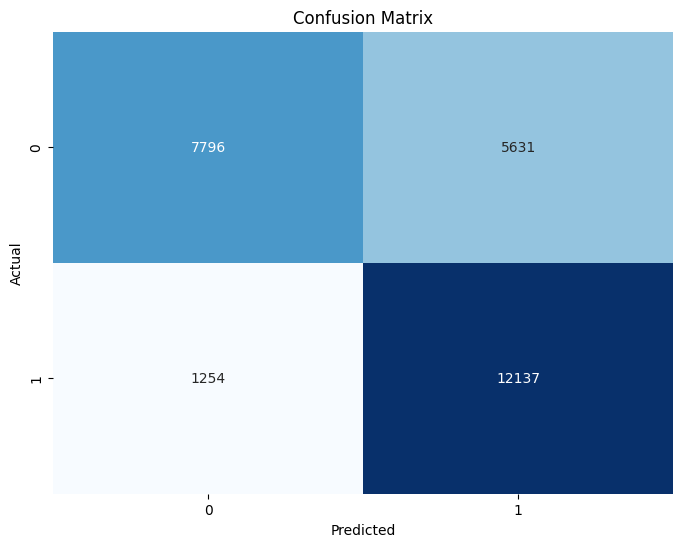

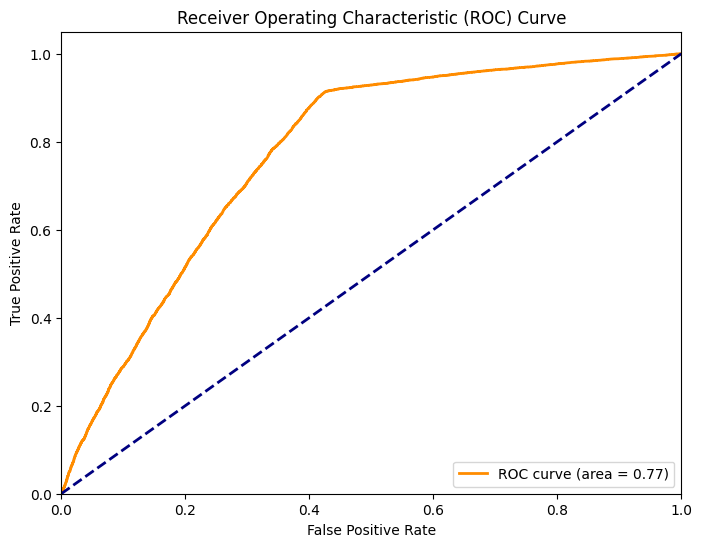


Model reloaded in inference mode. Evaluating again to confirm consistency:

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.58      0.69     13427
           1       0.68      0.91      0.78     13391

    accuracy                           0.74     26818
   macro avg       0.77      0.74      0.74     26818
weighted avg       0.77      0.74      0.74     26818



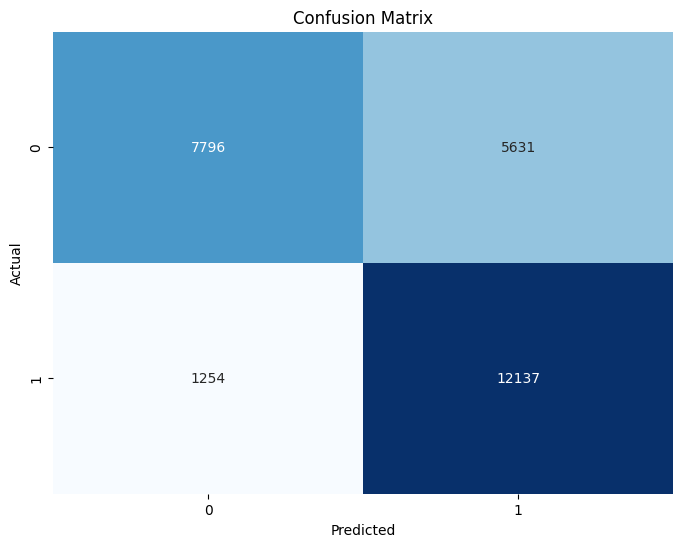

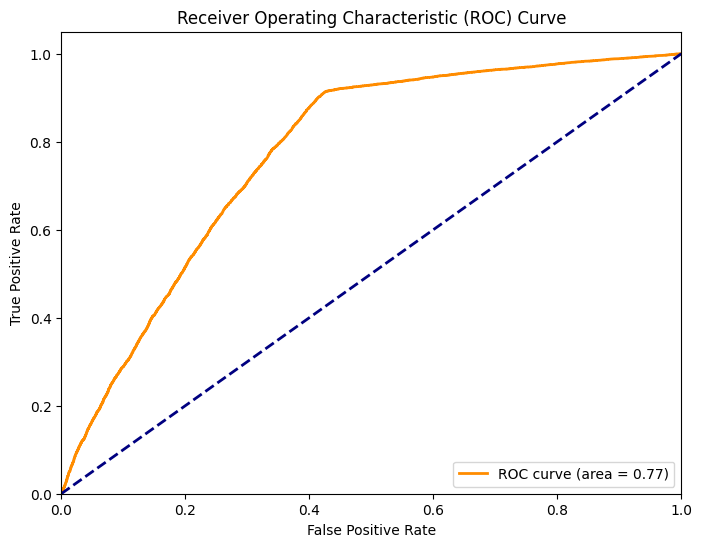

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import joblib
import os

# Define the CustomerProminencePredictor class (unchanged from previous response)
class CustomerProminencePredictor:
    def __init__(self, train=True, model_path='prominence_model.h5', scaler_path='scaler.save',
                 columns_path='training_columns.save'):
        self.model_path = model_path
        self.scaler_path = scaler_path
        self.columns_path = columns_path
        self.le_income = LabelEncoder()
        self.le_num_policies = LabelEncoder()

        if train:
            self.scaler = StandardScaler()
            self.model = None
            self.all_columns = None
        else:
            if not all(os.path.exists(path) for path in [model_path, scaler_path, columns_path]):
                raise FileNotFoundError("One or more model files are missing. Please train the model first.")
            self.scaler = joblib.load(scaler_path)
            self.model = load_model(model_path)
            self.all_columns = joblib.load(columns_path)
            self.le_income = joblib.load('le_income.save')
            self.le_num_policies = joblib.load('le_num_policies.save')

    def load_and_preprocess(self, data, is_train=True):
        data = data.copy()
        if is_train:
            data['income'] = self.le_income.fit_transform(data['income'])
            data['num_policies'] = self.le_num_policies.fit_transform(data['num_policies'])
        else:
            data['income'] = self.le_income.transform(data['income'])
            data['num_policies'] = self.le_num_policies.transform(data['num_policies'])

        type_policy_map = {'Silver': 0, 'Gold': 1, 'Platinum': 2}
        data['type_of_policy'] = data['type_of_policy'].map(type_policy_map)

        categorical_cols = ['gender', 'area', 'qualification', 'policy']
        data = pd.get_dummies(data, columns=categorical_cols)

        numeric_cols = ['income', 'claim_amount', 'vintage', 'type_of_policy']
        for col in numeric_cols:
            data[col] = pd.to_numeric(data[col], errors='raise')

        if is_train:
            data[numeric_cols] = self.scaler.fit_transform(data[numeric_cols])
        else:
            data[numeric_cols] = self.scaler.transform(data[numeric_cols])

        data['claim_income_ratio'] = data['claim_amount'] / (data['income'] + 1e-6)
        data['policy_vintage'] = data['type_of_policy'] * data['vintage']

        if is_train:
            if 'cltv' not in data.columns:
                raise ValueError("'cltv' column missing in training data.")
            cltv_median = data['cltv'].median()
            data['Prominence'] = (data['cltv'] >= cltv_median).astype(int)
            print(f"Derived 'Prominence' from 'cltv' with median threshold: {cltv_median}")

            self.all_columns = [col for col in data.columns if col not in ['Prominence', 'id', 'cltv']]
            X = data.drop(['Prominence', 'id', 'cltv'], axis=1)
            y = data['Prominence']
            joblib.dump(self.le_income, 'le_income.save')
            joblib.dump(self.le_num_policies, 'le_num_policies.save')
            return X, y
        else:
            for col in self.all_columns:
                if col not in data.columns:
                    data[col] = 0
            return data[self.all_columns]

    def train_model(self, X_train, y_train, X_val, y_val):
        self.model = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            verbose=1
        )

        self.model.save(self.model_path)
        joblib.dump(self.scaler, self.scaler_path)
        joblib.dump(self.all_columns, self.columns_path)

        return history

    def evaluate_model(self, X_test, y_test):
        y_pred_proba = self.model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba >= 0.5).astype(int)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        return y_pred, y_pred_proba

# Load and preprocess training data
train_data = pd.read_csv('train_BRCpofr.csv')
print("Training Data Shape:", train_data.shape)
print("Training Data Head:\n", train_data.head())

predictor = CustomerProminencePredictor(train=True)
X_train_full, y_train_full = predictor.load_and_preprocess(train_data, is_train=True)
print("Preprocessed Training Features Shape:", X_train_full.shape)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)
print("Training Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)

# Train the model and get history
history = predictor.train_model(X_train, y_train, X_val, y_val)
print("Model training completed.")

# Visualize training history
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate model on validation set with visualizations
print("\nEvaluating Model on Validation Set:")
y_val_pred, y_val_pred_proba = predictor.evaluate_model(X_val, y_val)

# Load predictor in inference mode to verify
predictor_infer = CustomerProminencePredictor(train=False)
print("\nModel reloaded in inference mode. Evaluating again to confirm consistency:")
y_val_pred_infer, y_val_pred_proba_infer = predictor_infer.evaluate_model(X_val, y_val)